# Disciplines

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [4]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:29:58: *** Start Sampling execution ***
    INFO - 17:29:58: Sampling
    INFO - 17:29:58:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:29:58:    MDO formulation: MDF
    INFO - 17:29:58: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:30:00:    100%|██████████| 100/100 [00:01<00:00, 57.23 it/sec]
    INFO - 17:30:00: *** End Sampling execution (time: 0:00:01.772045) ***


In [7]:
import matplotlib.pyplot as plt
import pprint

In [8]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([9.72543781e-07]),
 'length': array([0.]),
 'mtom': array([0.42059768]),
 'span': array([0.]),
 'tofl': array([0.01451162]),
 'vapp': array([0.00015426]),
 'vz': array([7.06481668e-05])}

In [10]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([1.35573038e-06]),
 'length': array([0.]),
 'mtom': array([0.62946367]),
 'span': array([0.]),
 'tofl': array([0.02216207]),
 'vapp': array([0.00022881]),
 'vz': array([0.00010396])}

In [11]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00852155]),
 'cef': array([1.00566636]),
 'fm': array([0.10036764]),
 'gi': array([0.38656094]),
 'length': array([39.75]),
 'mtom': array([76422.68379674]),
 'sef': array([1.00613398]),
 'span': array([40.24922359]),
 'tofl': array([1165.70681043]),
 'vapp': array([60.78523905]),
 'vi': array([0.78770926]),
 'vz': array([6.78386844])}

In [13]:
variance = statistics.compute_variance()
variance

{'aef': array([6.81645596e-05]),
 'cef': array([6.36776767e-05]),
 'fm': array([0.00038875]),
 'gi': array([0.00015218]),
 'length': array([0.]),
 'mtom': array([377120.26809291]),
 'sef': array([6.78384882e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([295.76320574]),
 'vapp': array([0.06259838]),
 'vi': array([0.00013086]),
 'vz': array([0.02887258])}

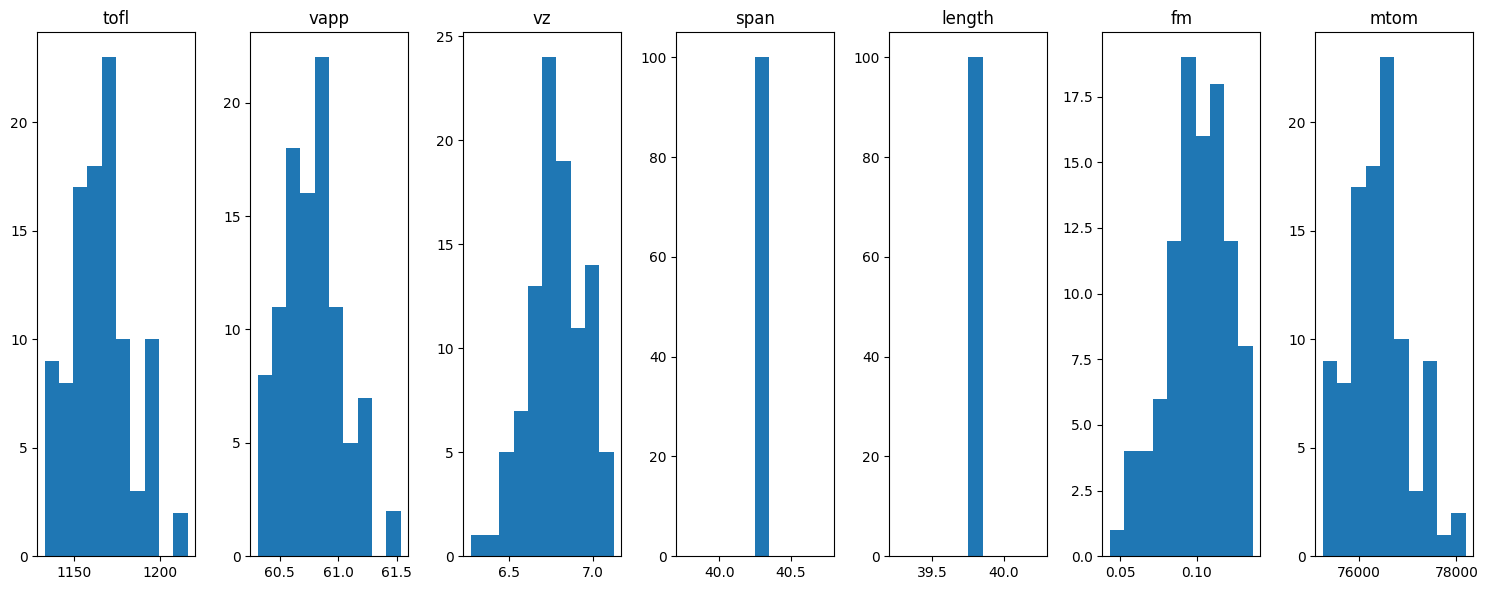

In [14]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [15]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 17:30:03: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:30:03: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:30:03: SobolAnalysisSamplingPhase
    INFO - 17:30:03:    Disciplines: PolyReg_Sampling
    INFO - 17:30:03:    MDO formulation: MDF
    INFO - 17:30:03: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:30:04:    100%|██████████| 96/96 [00:01<00:00, 71.23 it/sec]
    INFO - 17:30:04: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.371512) ***


GROUP        inputs                                           outputs         \
VARIABLE         gi        vi       aef       cef       sef        fm length   
COMPONENT         0         0         0         0         0         0      0   
0          0.394131  0.779313  1.028623  1.018127  1.006415  0.065407  39.75   
1          0.366964  0.764723  1.014139  0.994315  0.994671  0.077056  39.75   
2          0.394951  0.799486  1.009626  1.024286  1.003858  0.096466  39.75   
3          0.375284  0.796036  1.013230  0.997688  1.001509  0.117969  39.75   
4          0.375179  0.799914  1.017345  0.996241  1.006883  0.122789  39.75   
..              ...       ...       ...       ...       ...       ...    ...   
91         0.365560  0.778220  1.020575  1.009792  1.001509  0.076490  39.75   
92         0.398343  0.776086  1.007875  1.003573  1.006883  0.086544  39.75   
93         0.387046  0.772072  1.007799  1.001951  1.003720  0.082658  39.75   
94         0.400720  0.781155  1.002871  0.993853  1.014974  0.106662  39.75   
95         0.394662  0.778199  0.997953  1.006463  1.010079  0.091690  39.75   

GROUP                                                                 
VARIABLE           mtom       span         tofl       vapp        vz  
COMPONENT             0          0            0          0         0  
0          76162.844784  40.249224  1158.393121  60.634721  6.721294  
1          76413.703966  40.249224  1165.388355  60.799037  6.748779  
2          76236.273707  40.249224  1160.434270  60.671513  6.823709  
3          76731.838564  40.249224  1174.301137  60.923037  6.672687  
4          76990.732483  40.249224  1181.581749  61.027332  6.580161  
..                  ...        ...          ...        ...       ...  
91         76988.294917  40.249224  1181.515528  60.996307  6.560166  
92         75878.173271  40.249224  1150.469751  60.567665  6.928415  
93         76102.808185  40.249224  1156.707051  60.663036  6.870060  
94         76102.948002  40.249224  1156.721032  60.683916  6.901950  
95         76140.447834  40.249224  1157.756493  60.679261  6.923785  

[96 rows x 12 columns]

In [17]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([1.58737936]), 'vi': array([0.22880279]), 'aef': array([0.34443006]), 'cef': array([0.26600075]), 'sef': array([1.23937565])}], 'vapp': [{'gi': array([1.28719016]), 'vi': array([0.17885882]), 'aef': array([0.16555577]), 'cef': array([0.16426632]), 'sef': array([1.09705403])}], 'vz': [{'gi': array([1.50357328]), 'vi': array([-0.04439069]), 'aef': array([1.17239985]), 'cef': array([0.15747241]), 'sef': array([0.71653776])}], 'fm': [{'gi': array([-0.30225917]), 'vi': array([0.32265254]), 'aef': array([-0.1788591]), 'cef': array([-0.08306504]), 'sef': array([-0.30228368])}], 'mtom': [{'gi': array([1.5891458]), 'vi': array([0.22957271]), 'aef': array([0.34414938]), 'cef': array([0.26547921]), 'sef': array([1.24604873])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[-0.3397443]]), 'aef': array([[-0.87266637]]), 'cef': array([[-0.73862349]]), 'sef': array([[0.79048753]])}, 'vi': {'gi': array([[-0.3397443]]), 'vi': 

In [18]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.1788591]),
         'cef': array([-0.08306504]),
         'gi': array([-0.30225917]),
         'sef': array([-0.30228368]),
         'vi': array([0.32265254])}],
 'mtom': [{'aef': array([0.34414938]),
           'cef': array([0.26547921]),
           'gi': array([1.5891458]),
           'sef': array([1.24604873]),
           'vi': array([0.22957271])}],
 'tofl': [{'aef': array([0.34443006]),
           'cef': array([0.26600075]),
           'gi': array([1.58737936]),
           'sef': array([1.23937565]),
           'vi': array([0.22880279])}],
 'vapp': [{'aef': array([0.16555577]),
           'cef': array([0.16426632]),
           'gi': array([1.28719016]),
           'sef': array([1.09705403]),
           'vi': array([0.17885882])}],
 'vz': [{'aef': array([1.17239985]),
         'cef': array([0.15747241]),
         'gi': array([1.50357328]),
         'sef': array([0.71653776]),
         'vi': array([-0.04439069])}]}
{'fm': [{'aef': array([0.18183831]),
     

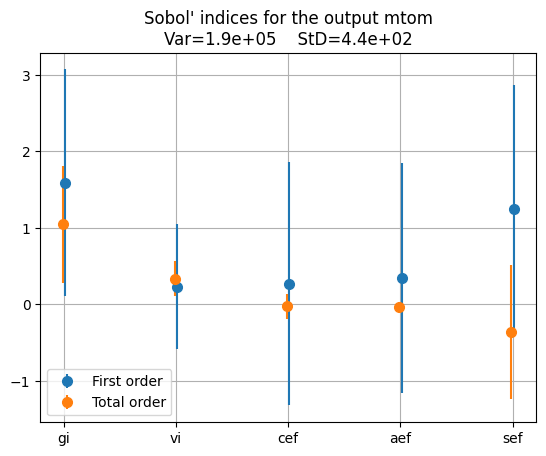

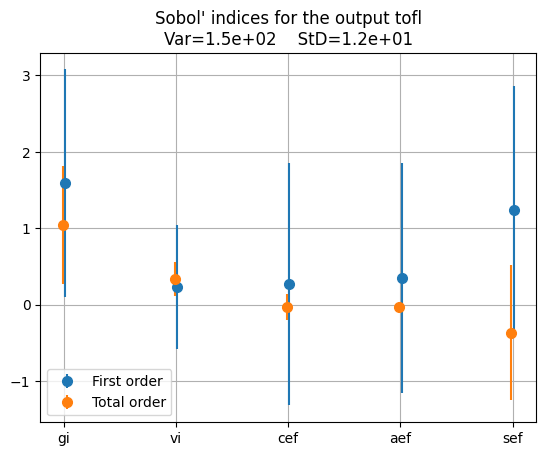

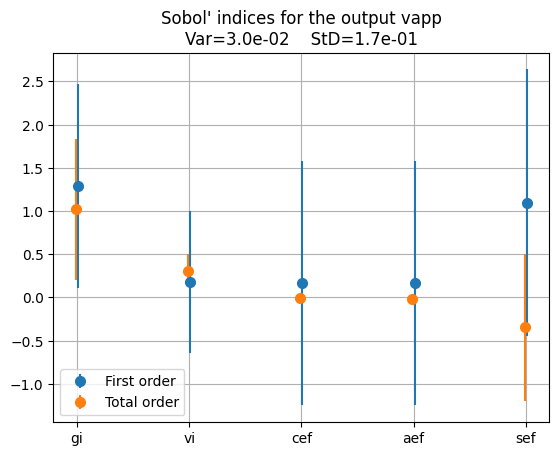

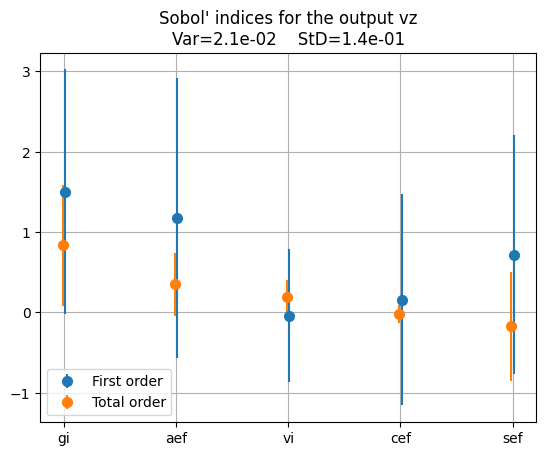

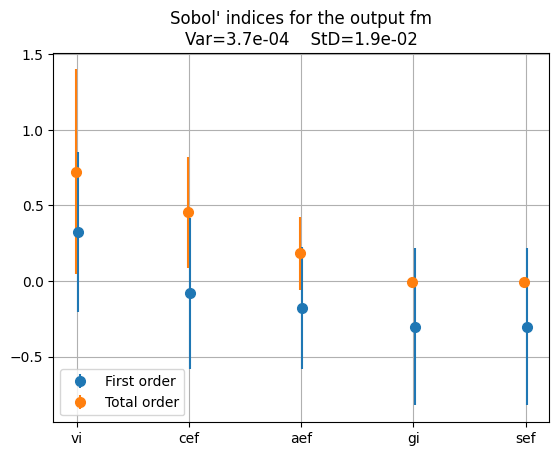

In [19]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))